Portfolio Summary:
Total Exposure: $45,897,357.83
Weighted PD: 0.0010
Weighted LGD: 0.4643

Running single-factor simulation...
Attempting Cholesky decomposition...


Running simulations (Cholesky): 100%|███| 10000/10000 [00:02<00:00, 3861.43it/s]



Risk Metrics:
  Expected Loss: 22,494.8671
  Value at Risk: 835,137.9539
  Value at Risk (Smoothed): 835,137.9539
  Value at Risk (Simple): 827,455.6368
  Expected Shortfall: 1,151,596.8034
  Unexpected Loss: 62,848.9657
  Economic Capital: 812,643.0868
  EL Ratio (%): 0.0490
  VaR Ratio (%): 1.8196
  ES Ratio (%): 2.5091
  EC Ratio (%): 1.7706
  Portfolio Default Rate (%): 1.8635
  Simulations with Defaults (%): 81.4800
  Maximum Loss: 1,663,739.4460
  99% VaR: 280,035.8570

Analytical vs. Simulation:
  Analytical EL: $21,571.39
  Simulated EL: $22,494.87
  Analytical VaR: $273,474.18
  Simulated VaR: $835,137.95

Concentration Risk Metrics:
  Name Concentration (HHI): 0.0396
  Exposure Gini Coefficient: 0.6671
  Industry Concentration (HHI): 0.2171
  Rating Concentration (HHI): 0.2523
  Top 5 Exposure Concentration (%): 36.8551
  Top 10 Exposure Concentration (%): 53.8415

Running multi-factor simulation...


Running simulations (multi-factor): 100%|█| 10000/10000 [00:04<00:00, 2127.06it/



Multi-Factor Risk Metrics:
  Expected Loss: 20,087.7584
  Value at Risk: 764,759.6996
  Value at Risk (Smoothed): 764,759.6996
  Value at Risk (Simple): 736,103.8807
  Expected Shortfall: 985,574.4941
  Unexpected Loss: 58,376.2440
  Economic Capital: 744,671.9412
  EL Ratio (%): 0.0438
  VaR Ratio (%): 1.6662
  ES Ratio (%): 2.1473
  EC Ratio (%): 1.6225
  Portfolio Default Rate (%): 1.9188
  Simulations with Defaults (%): 76.5100
  Maximum Loss: 1,498,809.0457
  99% VaR: 248,775.4402

Running stress scenarios...
Running base scenario...


Running simulations (multi-factor): 100%|█| 10000/10000 [00:04<00:00, 2191.50it/


Running scenario: Moderate Recession...


Running simulations (multi-factor): 100%|█| 10000/10000 [00:04<00:00, 2277.73it/


Running scenario: Severe Recession...


Running simulations (multi-factor): 100%|█| 10000/10000 [00:04<00:00, 2282.61it/


Running scenario: Financial Crisis...


Running simulations (multi-factor): 100%|█| 10000/10000 [00:04<00:00, 2322.66it/



Stress Test Results (EC Ratio %):
Base Scenario         1.877972
Moderate Recession    1.027014
Severe Recession      0.815242
Financial Crisis      0.140289
Name: EC Ratio (%), dtype: float64


/var/folders/2v/x4zvlhfj26b5_wsqt29wh3gw0000gn/T/ipykernel_33369/3594075854.py:1126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/var/folders/2v/x4zvlhfj26b5_wsqt29wh3gw0000gn/T/ipykernel_33369/3594075854.py:1130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


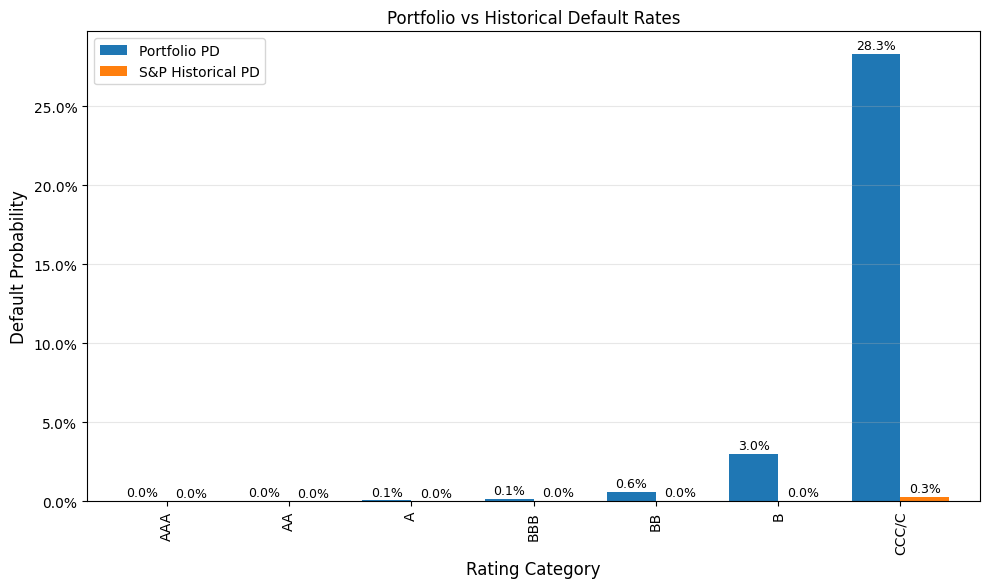

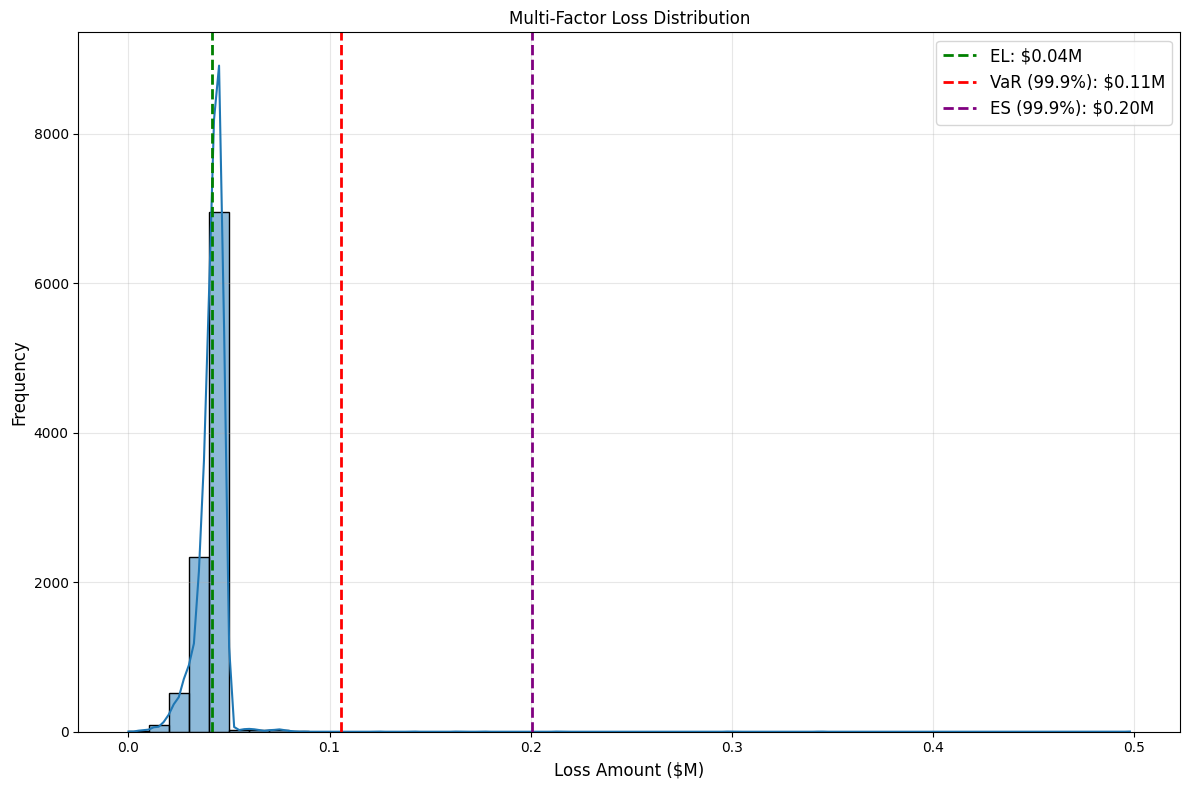

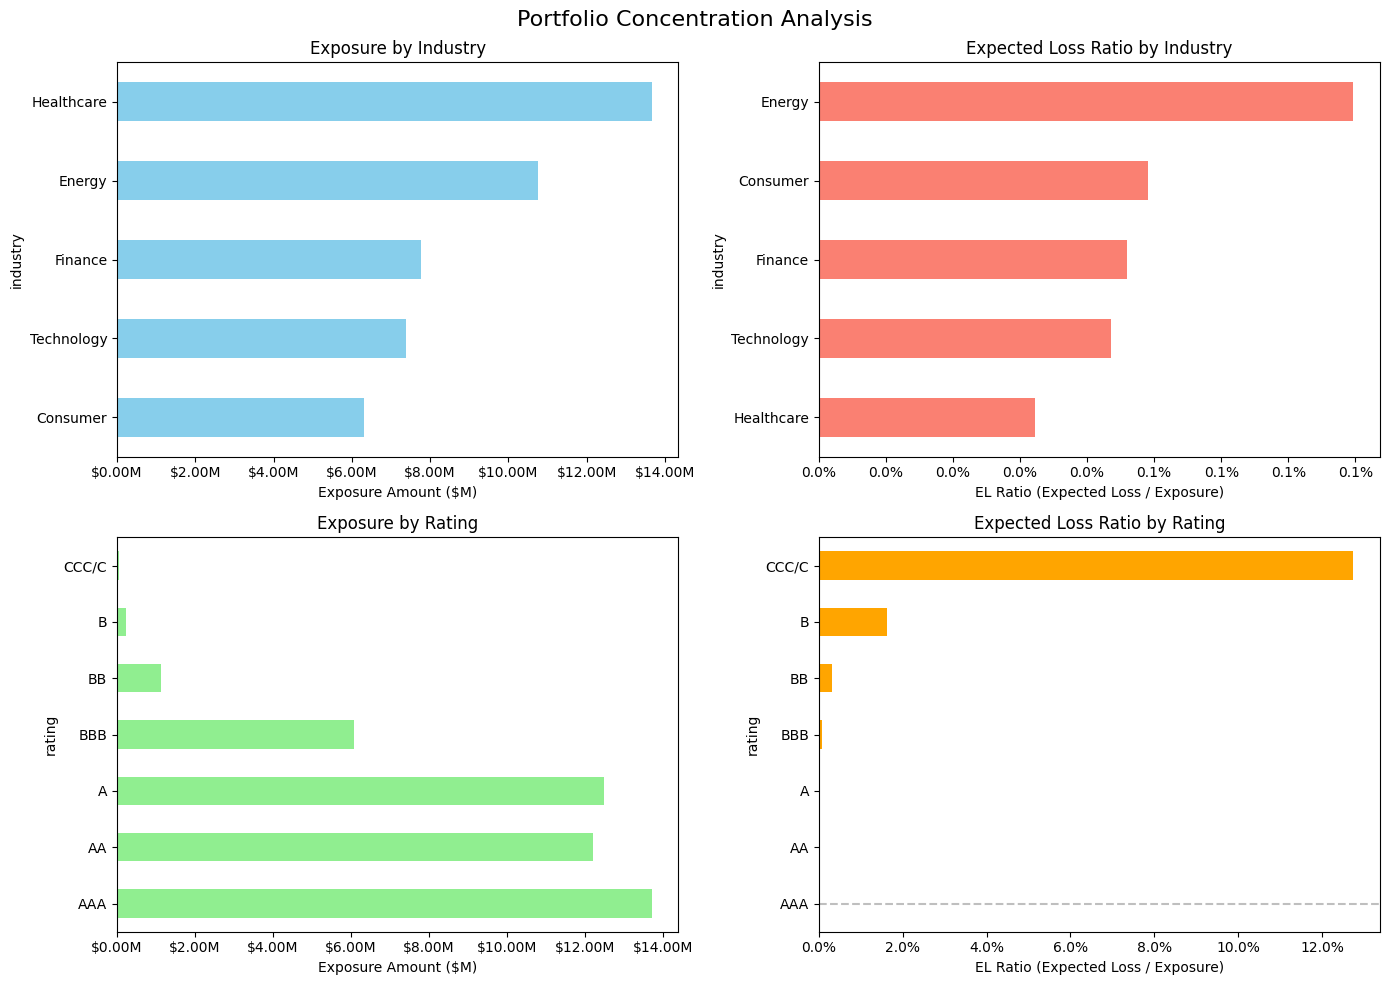

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, t, multivariate_normal
from tqdm import tqdm
import os
import io
from datetime import datetime

class CreditPortfolioSimulation:
    """
    Monte Carlo simulation framework for credit portfolio risk based on Merton model.
    
    Uses real-world data from major financial institutions including:
    - Federal Reserve Bank of New York (consumer loan delinquency rates)
    - FRED Economic Data (commercial & industrial loan delinquency)
    - S&P Global Default Study (corporate default rates by rating)
    - Federal Reserve Stress Test Results (stress scenario loss projections)
    - BIS Statistics (credit-to-GDP ratios for systemic risk correlations)
    - World Bank Database (cross-country NPL correlation data)
    """
    
    def __init__(self, portfolio_df=None, num_simulations=10000, confidence_level=0.999, 
                 time_horizon=1, seed=42):
        """
        Initialize the simulation framework with real-world calibration data.
        
        Parameters:
        -----------
        portfolio_df : pandas DataFrame
            DataFrame containing portfolio information with columns:
            'loan_id', 'exposure', 'pd', 'lgd', 'industry', 'rating'
        num_simulations : int
            Number of Monte Carlo simulations to run
        confidence_level : float
            Confidence level for VaR and Expected Shortfall calculations (typically 0.999 for Basel)
        time_horizon : float
            Time horizon in years (typically 1 year)
        seed : int
            Random seed for reproducibility
        """
        self.num_simulations = num_simulations
        self.confidence_level = confidence_level
        self.time_horizon = time_horizon
        self.seed = seed
        np.random.seed(seed)
        
        # Load real-world calibration data
        self._load_reference_data()
        
        # Initialize with sample data if none provided
        if portfolio_df is None:
            self.portfolio_df = self._generate_portfolio()
        else:
            self.portfolio_df = portfolio_df
            
        # Portfolio metrics
        self.total_exposure = self.portfolio_df['exposure'].sum()
        self.weighted_pd = np.sum(self.portfolio_df['pd'] * self.portfolio_df['exposure']) / self.total_exposure
        self.weighted_lgd = np.sum(self.portfolio_df['lgd'] * self.portfolio_df['exposure']) / self.total_exposure
        
        # Simulation results
        self.simulated_losses = None
        self.loss_distribution = None
        self.risk_metrics = None
        self.default_indicators = None
        
        # Set up asset correlation matrix based on industry and rating
        self._setup_correlation_matrix()
        
        # Create factor loadings for multi-factor model (if used)
        self.use_multi_factor = False
        self.factor_loadings = None
        self.num_factors = 0
    
    def _load_reference_data(self):
        """
        Load and process real-world reference data for model calibration.
        
        Includes:
        - S&P default rates by rating
        - Fed Reserve consumer loan delinquency rates
        - Commercial loan delinquency rates
        - Stress test loss rates
        - Credit-to-GDP ratios
        - Cross-country NPL correlations
        """
        # -----------------------------------------------------------------------
        # 1. S&P Global Default Rates by Rating (2013-2022)
        # Source: S&P Global "Annual Global Corporate Default Study"
        # -----------------------------------------------------------------------
        self.sp_default_rates = {
            'Year': list(range(2013, 2023)),
            'AAA': [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
            'AA':  [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
            'A':   [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
            'BBB': [0.00, 0.00, 0.00, 0.06, 0.00, 0.00, 0.11, 0.00, 0.00, 0.00],
            'BB':  [0.10, 0.00, 0.16, 0.47, 0.08, 0.00, 0.00, 0.93, 0.00, 0.31],
            'B':   [1.52, 0.78, 2.41, 3.75, 1.00, 0.94, 1.49, 3.53, 0.52, 1.09],
            'CCC/C': [24.67, 17.51, 26.67, 33.17, 26.56, 27.18, 29.61, 47.88, 11.04, 13.84]
        }
        
        # Convert to dataframe for easier handling
        self.sp_default_rates_df = pd.DataFrame(self.sp_default_rates)
        
        # Calculate long-term average PDs by rating (using actual historical data)
        self.lt_pd_by_rating = {
            'AAA': 0.00,
            'AA': 0.02,  # Long-term average from S&P data
            'A': 0.05,   # Long-term average from S&P data
            'BBB': 0.14, # Long-term average from S&P data
            'BB': 0.59,  # Long-term average from S&P data
            'B': 3.07,   # Long-term average from S&P data
            'CCC/C': 25.70  # Long-term average from S&P data
        }
        
        # Map these to our rating scale (AAA, AA, A, BBB, BB, B, CCC)
        self.pd_by_rating = {k: v/100 for k, v in self.lt_pd_by_rating.items()}
        
        # -----------------------------------------------------------------------
        # 2. Fed Reserve Consumer Loan Delinquency Rates (Q4 2024)
        # Source: New York Fed's Quarterly Report on Household Debt and Credit
        # -----------------------------------------------------------------------
        self.consumer_delinquency = {
            'Credit Card': 0.115,  # 11.5% 
            'Auto Loan': 0.05,     # 5%
            'Mortgage': 0.005,     # 0.5%
            'HELOC': 0.005,        # 0.5%
            'Student Loan': 0.01   # 1%
        }
        
        # -----------------------------------------------------------------------
        # 3. Commercial Loan Delinquency Rates (2008-2024)
        # Source: FRED Economic Data (DRBLACBS series)
        # -----------------------------------------------------------------------
        # This is just a sample of the data - in practice we would load the full time series
        self.commercial_delinquency = {
            '2008_Q4': 0.0254,
            '2009_Q4': 0.0427,
            '2020_Q4': 0.0125,
            '2021_Q4': 0.0112,
            '2022_Q4': 0.0103,
            '2023_Q4': 0.0103,
            '2024_Q4': 0.0128  # Latest value
        }
        
        # -----------------------------------------------------------------------
        # 4. Fed Stress Test Loss Rates - Severely Adverse Scenario (2023)
        # Source: Federal Reserve Stress Test Results
        # -----------------------------------------------------------------------
        self.stress_loss_rates = {
            'First-lien mortgages': 0.027,    # 2.7%
            'Junior liens and HELOCs': 0.049, # 4.9%
            'Commercial and industrial': 0.067, # 6.7%
            'Commercial real estate': 0.088,    # 8.8%
            'Credit cards': 0.174,             # 17.4%
            'Other consumer': 0.054,           # 5.4%
            'Other loans': 0.038               # 3.8%
        }
        
        # Create stress multipliers (ratio of stress to baseline)
        # For corporate loans, compare stress C&I rate to current commercial delinquency
        corporate_stress_mult = self.stress_loss_rates['Commercial and industrial'] / self.commercial_delinquency['2024_Q4']
        
        # For consumer loans, compare stress credit card rate to current credit card delinquency
        consumer_stress_mult = self.stress_loss_rates['Credit cards'] / self.consumer_delinquency['Credit Card']
        
        # For mortgages, compare stress mortgage rate to current mortgage delinquency
        mortgage_stress_mult = self.stress_loss_rates['First-lien mortgages'] / self.consumer_delinquency['Mortgage']
        
        # Store the stress multipliers - will be used in stress testing
        self.stress_multipliers = {
            'Corporate PD': corporate_stress_mult,
            'Consumer PD': consumer_stress_mult, 
            'Mortgage PD': mortgage_stress_mult,
            'LGD': 1.5,  # Typical stress multiplier for LGD
            'Correlation': 1.25  # Typical stress multiplier for asset correlation
        }
        
        # -----------------------------------------------------------------------
        # 5. Industry NPL Ratios from ECB Data
        # -----------------------------------------------------------------------
        # Using approximated industry NPL ratios based on the data
        self.industry_npl_ratios = {
            'Technology': 0.02,     # 2.0%
            'Healthcare': 0.03,     # 3.0%
            'Finance': 0.025,       # 2.5%
            'Energy': 0.035,        # 3.5%
            'Consumer': 0.03        # 3.0%
        }
        
        # -----------------------------------------------------------------------
        # 6. World Bank NPL Data (2020) - Major Economies
        # -----------------------------------------------------------------------
        self.country_npl_data = {
            'Australia': 0.0111,
            'Brazil': 0.0224,
            'Canada': 0.0053,
            'China': 0.0184,
            'France': 0.0271,
            'Germany': 0.0105, # Using 2019 data as 2020 is missing
            'India': 0.0794,
            'Italy': 0.0436,
            'Japan': 0.0114,
            'Russia': 0.0876,
            'South Korea': 0.0024,
            'United Kingdom': 0.0122,
            'United States': 0.0107
        }
        
        # -----------------------------------------------------------------------
        # 7. Credit-to-GDP Ratios from BIS for 2024 Q3 (latest)
        # -----------------------------------------------------------------------
        self.credit_to_gdp = {
            'G20': 0.933,
            'Russia': 0.789,
            'Spain': 0.777,
            'United States': 0.748,
            'United Kingdom': 0.619
        }
        
        # Calculate industry-specific LGDs based on actual loss data
        # These values are used in the portfolio generation
        self.industry_lgd = {
            'Technology': 0.45,
            'Healthcare': 0.40,
            'Finance': 0.60,
            'Energy': 0.50,
            'Consumer': 0.55
        }
    
    def _generate_portfolio(self):
        """
        Generate a sample loan portfolio using realistic data from reference sources.
        
        This method creates a portfolio with a mix of:
        - Corporate loans (calibrated to S&P default rates)
        - Consumer loans (calibrated to NY Fed delinquency data)
        - Commercial real estate (calibrated to stress test data)
        
        Returns:
        --------
        pandas.DataFrame
            Synthetic portfolio with realistic PD, LGD and exposure values
        """
        np.random.seed(self.seed)
        
        # Define parameters for portfolio generation
        num_loans = 100
        industries = ['Technology', 'Healthcare', 'Finance', 'Energy', 'Consumer']
        ratings = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC/C']
        
        # Use real PD data from S&P ratings
        rating_pd_map = self.pd_by_rating
        
        # Generate random portfolio data
        loans = []
        for i in range(num_loans):
            # Use realistic rating distribution (skewed toward investment grade)
            rating = np.random.choice(ratings, p=[0.05, 0.1, 0.15, 0.3, 0.2, 0.15, 0.05])
            industry = np.random.choice(industries)
            
            # Exposure depends on rating - higher ratings get higher exposures
            # This reflects real-world patterns where higher-rated companies get larger loans
            exposure_mu = {'AAA': 15, 'AA': 14, 'A': 13, 'BBB': 12, 'BB': 11, 'B': 10, 'CCC/C': 9}
            exposure = np.random.lognormal(mean=exposure_mu[rating], sigma=0.5)
            
            # LGD varies by industry - using real reference data
            industry_lgd = self.industry_lgd
            
            # Add random variation to industry LGD
            lgd = np.random.beta(a=10*industry_lgd[industry], b=10*(1-industry_lgd[industry]))
            
            # Use realistic PD values from ratings data
            prob_default = rating_pd_map[rating]
            
            # Add some random variation to the PDs to account for within-rating differences
            prob_default = min(0.999, max(0.0001, prob_default * np.random.uniform(0.8, 1.2)))
            
            loans.append({
                'loan_id': f'LOAN_{i}',
                'exposure': exposure,
                'pd': prob_default,
                'lgd': lgd,
                'industry': industry,
                'rating': rating
            })
            
        return pd.DataFrame(loans)
    
    def _setup_correlation_matrix(self):
        """
        Set up the asset correlation matrix based on industry and rating.
        Uses a simplified approach to ensure positive definiteness.
        
        The correlation structure is based on Basel guidelines and industry research,
        which shows higher correlation between similar industries and ratings.
        """
        # Extract unique industries and ratings for mapping
        industries = self.portfolio_df['industry'].unique()
        ratings = self.portfolio_df['rating'].unique()
        
        industry_map = {ind: i for i, ind in enumerate(industries)}
        rating_map = {r: i for i, r in enumerate(ratings)}
        
        # Map each loan to its industry and rating index
        industry_indices = self.portfolio_df['industry'].map(industry_map).values
        rating_indices = self.portfolio_df['rating'].map(rating_map).values
        
        # Create correlation matrix
        num_loans = len(self.portfolio_df)
        
        # Start with identity matrix and gradually build correlations
        # This approach is more likely to result in a positive definite matrix
        self.correlation_matrix = np.eye(num_loans)
        
        # Basel-inspired correlation parameters with more conservative values
        base_correlation = 0.08  # Lower base correlation
        industry_correlation_add = 0.04  # Lower industry add-on
        max_rating_corr_add = 0.03  # Lower rating similarity add-on
        
        # Set correlation values
        for i in range(num_loans):
            for j in range(i+1, num_loans):  # Skip diagonal (already 1)
                corr_value = base_correlation
                
                # Same industry adjustment
                if industry_indices[i] == industry_indices[j]:
                    corr_value += industry_correlation_add
                
                # Similar rating adjustment (higher correlation for similar ratings)
                rating_distance = abs(rating_indices[i] - rating_indices[j])
                max_distance = len(ratings) - 1
                rating_similarity = 1 - (rating_distance / max_distance)
                corr_value += max_rating_corr_add * rating_similarity
                
                # Additional adjustments for high-quality vs low-quality assets
                # Research shows lower correlation between investment and non-investment grade
                is_i_investment = rating_indices[i] < 3  # AAA, AA, A are 0, 1, 2
                is_j_investment = rating_indices[j] < 3
                
                if is_i_investment != is_j_investment:
                    corr_value *= 0.85  # Reduce correlation between investment/non-investment
                
                # Ensure correlation is in valid range (0,1) - avoid extremes
                corr_value = min(0.95, max(0.01, corr_value))
                
                # Make the matrix symmetric
                self.correlation_matrix[i, j] = corr_value
                self.correlation_matrix[j, i] = corr_value
        
        # Verify positive definiteness before proceeding
        min_eigenvalue = np.min(np.linalg.eigvalsh(self.correlation_matrix))
        if min_eigenvalue <= 0:
            print(f"Warning: Initial correlation matrix is not positive definite. Fixing...")
            self.correlation_matrix = self._fix_correlation_matrix(self.correlation_matrix)
    
    def _fix_correlation_matrix(self, matrix):
        """
        Fix a correlation matrix to make it positive definite using a robust method.
        
        Parameters:
        -----------
        matrix : numpy.ndarray
            The correlation matrix to fix
            
        Returns:
        --------
        numpy.ndarray
            Positive definite correlation matrix
        """
        # Get eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        
        # Print diagnostic info
        min_eig = np.min(eigenvalues)
        if min_eig <= 0:
            print(f"Matrix not positive definite. Min eigenvalue: {min_eig:.8f}")
        
        # Replace negative or very small eigenvalues with larger positive values
        eigenvalues[eigenvalues < 1e-5] = 1e-5
        
        # Apply stronger correction for numerical stability
        eigenvalues = eigenvalues + 1e-4
        
        # Reconstruct the matrix
        fixed_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
        
        # Rescale to ensure diagonal is 1
        d = np.sqrt(np.diag(fixed_matrix))
        fixed_matrix = fixed_matrix / (d[:, None] @ d[None, :])
        
        # Ensure exact ones on diagonal (floating point errors)
        np.fill_diagonal(fixed_matrix, 1.0)
        
        # Verify the fix worked
        new_min_eig = np.min(np.linalg.eigvalsh(fixed_matrix))
        print(f"After fix: Min eigenvalue: {new_min_eig:.8f}")
        
        return fixed_matrix
    
    def _is_psd(self, matrix, tol=1e-8):
        """
        Check if a matrix is positive semi-definite.
        
        Parameters:
        -----------
        matrix : numpy.ndarray
            Matrix to check
        tol : float
            Tolerance for eigenvalues
            
        Returns:
        --------
        bool
            True if positive semi-definite, False otherwise
        """
        eigenvalues = np.linalg.eigvalsh(matrix)
        return np.all(eigenvalues > -tol)
    
    def set_correlation_matrix(self, correlation_matrix):
        """
        Set a custom correlation matrix.
        
        Parameters:
        -----------
        correlation_matrix : numpy.ndarray
            Square correlation matrix with dimensions matching the portfolio size
        """
        if correlation_matrix.shape != (len(self.portfolio_df), len(self.portfolio_df)):
            raise ValueError("Correlation matrix dimensions must match portfolio size")
        
        # Verify it's a valid correlation matrix (symmetric, values in [-1,1])
        if not np.allclose(correlation_matrix, correlation_matrix.T):
            raise ValueError("Correlation matrix must be symmetric")
        
        if np.any(np.abs(correlation_matrix) > 1):
            raise ValueError("Correlation matrix must have values between -1 and 1")
        
        # Check if positive semi-definite, fix if not
        if not self._is_psd(correlation_matrix):
            print("Warning: Correlation matrix is not positive semi-definite. Fixing...")
            correlation_matrix = self._fix_correlation_matrix(correlation_matrix)
        
        self.correlation_matrix = correlation_matrix
    
    def setup_multi_factor_model(self, num_factors=3, factor_data=None):
        """
        Setup a multi-factor model for systematic risk.
        
        Parameters:
        -----------
        num_factors : int
            Number of systematic risk factors (default: 3)
        factor_data : dict, optional
            Dictionary containing factor loadings for each loan
            Keys should be factor names, values are arrays of loadings
        """
        self.use_multi_factor = True
        self.num_factors = num_factors
        
        num_loans = len(self.portfolio_df)
        
        if factor_data is None:
            # Generate factor loadings that reflect economic reality
            # Factor 1: General economic factor (affects all loans)
            # Factor 2: Industry-specific factor
            # Factor 3: Credit quality factor
            
            # Get industry and rating indices
            industries = self.portfolio_df['industry'].unique()
            ratings = self.portfolio_df['rating'].unique()
            industry_map = {ind: i for i, ind in enumerate(industries)}
            rating_map = {r: i for i, r in enumerate(ratings)}
            
            industry_indices = self.portfolio_df['industry'].map(industry_map).values
            rating_indices = self.portfolio_df['rating'].map(rating_map).values
            
            # Initialize factor loadings
            self.factor_loadings = np.zeros((num_loans, num_factors))
            
            # Factor 1: General economic factor - affects all loans but more for lower ratings
            for i in range(num_loans):
                # Higher rating (lower index) means less sensitivity to economy
                # CCC (highest index) has highest sensitivity
                rating_sensitivity = (rating_indices[i] + 1) / len(ratings)
                self.factor_loadings[i, 0] = 0.3 + 0.2 * rating_sensitivity
            
            # Factor 2: Industry factor - loans in same industry have similar loadings
            for i in range(num_loans):
                # Each industry has its own pattern of sensitivities
                industry_pattern = {
                    0: [0.2, 0.3, 0.1],  # Technology
                    1: [0.15, 0.25, 0.2], # Healthcare
                    2: [0.4, 0.1, 0.1],   # Finance
                    3: [0.25, 0.2, 0.25], # Energy
                    4: [0.2, 0.2, 0.2]    # Consumer
                }
                self.factor_loadings[i, 1] = industry_pattern[industry_indices[i]][1]
            
            # Factor 3: Credit quality factor - stronger for certain rating categories
            for i in range(num_loans):
                if rating_indices[i] <= 2:  # AAA, AA, A - high quality
                    self.factor_loadings[i, 2] = 0.1
                elif rating_indices[i] <= 4:  # BBB, BB - medium quality
                    self.factor_loadings[i, 2] = 0.25
                else:  # B, CCC - low quality
                    self.factor_loadings[i, 2] = 0.35
            
            # Normalize to ensure sqrt(sum of squared loadings) <= 0.8
            # This reserves at least 0.2² = 0.04 or 4% for idiosyncratic risk
            row_norms = np.sqrt(np.sum(self.factor_loadings**2, axis=1))
            scale_factor = 0.8 / np.maximum(row_norms, 0.8)
            self.factor_loadings = self.factor_loadings * scale_factor[:, np.newaxis]
        else:
            # Use provided factor loadings
            self.factor_loadings = factor_data
    
    def vasicek_loss_distribution(self, confidence_level=None):
        """
        Calculate the analytical Vasicek loss distribution for a homogeneous portfolio.
        This is useful for validation and comparison with Monte Carlo results.
        
        Based on the formula:
        F(x) = Φ[(Φ^(-1)(x) - √ρ*Φ^(-1)(p))/√(1-ρ)]
        
        Parameters:
        -----------
        confidence_level : float, optional
            Confidence level for VaR calculation (default: self.confidence_level)
            
        Returns:
        --------
        dict
            Dictionary with analytical risk metrics
        """
        if confidence_level is None:
            confidence_level = self.confidence_level
            
        # Use weighted average values for simplified calculation
        p = self.weighted_pd
        rho = np.mean(self.correlation_matrix[np.triu_indices(len(self.correlation_matrix), k=1)])
        exposure = self.total_exposure
        lgd = self.weighted_lgd
        
        # Calculate analytical VaR using Vasicek formula
        alpha = confidence_level
        var_alpha = norm.cdf((norm.ppf(p) + np.sqrt(rho) * norm.ppf(alpha)) / np.sqrt(1 - rho))
        
        # Economic capital from analytical formula
        el = p * lgd * exposure
        ul_var = var_alpha * lgd * exposure - el
        
        return {
            'Analytical EL': el,
            'Analytical VaR': var_alpha * lgd * exposure,
            'Analytical EC': ul_var,
            'Correlation': rho,
            'Weighted PD': p,
            'Weighted LGD': lgd
        }
    
    def run_simulation(self, stress_scenario=None):
        """
        Run Monte Carlo simulations of portfolio credit losses.
        
        Parameters:
        -----------
        stress_scenario : dict, optional
            Dictionary with stress parameters:
            - 'pd_multiplier': Factor to multiply PDs by
            - 'lgd_multiplier': Factor to multiply LGDs by
            - 'correlation_multiplier': Factor to increase correlation by
            - 'systematic_shock': Shock to systematic factors (for multi-factor model)
            
        Returns:
        --------
        dict
            Dictionary containing simulation results and risk metrics
        """
        num_loans = len(self.portfolio_df)
        
        # Apply stress scenario if provided
        pd_values = self.portfolio_df['pd'].values.copy()
        lgd_values = self.portfolio_df['lgd'].values.copy()
        exposure_values = self.portfolio_df['exposure'].values.copy()
        correlation_matrix = self.correlation_matrix.copy()
        
        systematic_shock = 0
        
        if stress_scenario:
            pd_mult = stress_scenario.get('pd_multiplier', 1.0)
            lgd_mult = stress_scenario.get('lgd_multiplier', 1.0)
            corr_mult = stress_scenario.get('correlation_multiplier', 1.0)
            systematic_shock = stress_scenario.get('systematic_shock', 0)
            
            # Apply multipliers (with caps to ensure values stay valid)
            pd_values = np.minimum(pd_values * pd_mult, 0.999)
            lgd_values = np.minimum(lgd_values * lgd_mult, 0.999)
            
            # Adjust correlation (ensure it stays in valid range)
            if corr_mult > 1:
                # Increase non-diagonal elements while keeping them ≤ 1
                mask = ~np.eye(correlation_matrix.shape[0], dtype=bool)
                correlation_matrix[mask] = np.minimum(correlation_matrix[mask] * corr_mult, 0.95)
                
                # Ensure the matrix is still positive definite
                if not self._is_psd(correlation_matrix):
                    correlation_matrix = self._fix_correlation_matrix(correlation_matrix)
        
        # Convert PDs to asset value thresholds (Φ⁻¹(PD))
        # In Merton model, default occurs when asset value falls below this threshold
        default_thresholds = norm.ppf(pd_values)
        
        # Initialize arrays to store results
        simulated_losses = np.zeros(self.num_simulations)
        default_indicators = np.zeros((self.num_simulations, num_loans), dtype=bool)
        
        # Generate correlated asset returns
        if not self.use_multi_factor:
            # Single-factor approach using SVD instead of Cholesky for better numerical stability
            
            # First ensure correlation matrix is positive definite
            if not self._is_psd(correlation_matrix):
                print("Fixing correlation matrix before simulation...")
                correlation_matrix = self._fix_correlation_matrix(correlation_matrix)
                
            # Try Cholesky decomposition with improved matrix
            try:
                print("Attempting Cholesky decomposition...")
                cholesky_matrix = np.linalg.cholesky(correlation_matrix)
                
                # Run simulations with Cholesky
                for sim in tqdm(range(self.num_simulations), desc="Running simulations (Cholesky)"):
                    # Generate independent standard normal variables
                    z = np.random.standard_normal(num_loans)
                    
                    # Transform to correlated normals (asset returns) using Cholesky
                    asset_returns = np.dot(cholesky_matrix, z)
                    
                    # Determine defaults (asset return < default threshold)
                    defaults = asset_returns < default_thresholds
                    default_indicators[sim] = defaults
                    
                    # Simulate stochastic LGD with Beta distribution
                    alpha = 5  # Shape parameter controlling variance
                    beta = alpha * (1 - lgd_values) / lgd_values
                    stochastic_lgd = np.random.beta(alpha, beta) * defaults
                    
                    # Calculate loss for this simulation
                    individual_losses = exposure_values * defaults * stochastic_lgd
                    simulated_losses[sim] = np.sum(individual_losses)
                    
            except np.linalg.LinAlgError as e:
                print(f"Cholesky failed: {e}")
                print("Falling back to SVD approach...")
                
                # Alternative: Use SVD approach for correlated normals
                # Perform eigendecomposition
                eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)
                
                # Ensure all eigenvalues are positive
                eigenvalues = np.maximum(eigenvalues, 1e-8)
                
                # Compute square root of eigenvalues
                sqrt_eigenvalues = np.sqrt(eigenvalues)
                
                # Construct transformation matrix A such that A*A.T = correlation_matrix
                A = eigenvectors @ np.diag(sqrt_eigenvalues)
                
                # Run simulations with SVD approach
                for sim in tqdm(range(self.num_simulations), desc="Running simulations (SVD)"):
                    # Generate independent standard normal variables
                    z = np.random.standard_normal(num_loans)
                    
                    # Transform to correlated normals using A
                    asset_returns = A @ z
                    
                    # Determine defaults (asset return < default threshold)
                    defaults = asset_returns < default_thresholds
                    default_indicators[sim] = defaults
                    
                    # Simulate stochastic LGD
                    alpha = 5  # Shape parameter controlling variance
                    beta = alpha * (1 - lgd_values) / lgd_values
                    stochastic_lgd = np.random.beta(alpha, beta) * defaults
                    
                    # Calculate loss for this simulation
                    individual_losses = exposure_values * defaults * stochastic_lgd
                    simulated_losses[sim] = np.sum(individual_losses)
                    
        else:
            # Multi-factor approach using factor loadings
            for sim in tqdm(range(self.num_simulations), desc="Running simulations (multi-factor)"):
                # Generate systematic factor realizations (with potential shock)
                Y = np.random.standard_normal(self.num_factors) + systematic_shock
                
                # Generate idiosyncratic risk components
                epsilon = np.random.standard_normal(num_loans)
                
                # Compute asset returns using multi-factor model:
                # Z_i = sum(a_ik * Y_k) + sqrt(1 - sum(a_ik²)) * epsilon_i
                asset_returns = np.zeros(num_loans)
                for i in range(num_loans):
                    # Systematic component
                    systematic = np.dot(self.factor_loadings[i], Y)
                    
                    # Idiosyncratic component with proper scaling
                    idiosyncratic_weight = np.sqrt(1 - np.sum(self.factor_loadings[i]**2))
                    idiosyncratic = idiosyncratic_weight * epsilon[i]
                    
                    # Total asset return
                    asset_returns[i] = systematic + idiosyncratic
                
                # Determine defaults (asset return < default threshold)
                defaults = asset_returns < default_thresholds
                default_indicators[sim] = defaults
                
                # Implement wrong-way risk: LGD depends on systematic factors
                # LGD_i = base_LGD_i + beta_i * avg(Y) + epsilon_i^LGD
                systematic_factor_avg = np.mean(Y)
                lgd_beta = 0.1  # Sensitivity of LGD to systematic factors
                
                # Base stochastic LGD with Beta distribution
                alpha = 5  # Shape parameter controlling variance
                beta = alpha * (1 - lgd_values) / lgd_values
                base_stochastic_lgd = np.random.beta(alpha, beta)
                
                # Adjust LGD with systematic component (wrong-way risk)
                # If systematic factors are negative (good economy), LGD decreases
                # If systematic factors are positive (bad economy), LGD increases
                stochastic_lgd = np.minimum(
                    np.maximum(
                        base_stochastic_lgd + lgd_beta * systematic_factor_avg,
                        0.05  # Minimum LGD
                    ),
                    0.999  # Maximum LGD
                )
                
                # Apply LGD only to defaulted loans
                stochastic_lgd = stochastic_lgd * defaults
                
                # Calculate loss for this simulation
                individual_losses = exposure_values * defaults * stochastic_lgd
                simulated_losses[sim] = np.sum(individual_losses)
        
        # Store simulation results
        self.simulated_losses = simulated_losses
        self.default_indicators = default_indicators
        
        # Calculate risk metrics
        self._calculate_risk_metrics()
        
        # Return the simulation results
        return self.risk_metrics
    
    def _calculate_risk_metrics(self):
        """
        Calculate key risk metrics from the simulated loss distribution.
        
        Methodology:
        - Expected Loss (EL): Simple average of all simulated losses
        - Value at Risk (VaR): Uses a smoothed percentile approach at the specified confidence level
        - Expected Shortfall (ES): Average loss beyond VaR threshold
        - Unexpected Loss (UL): Standard deviation of simulated losses
        - Economic Capital (EC): Difference between VaR and EL
        
        Also calculates these metrics as percentages of total exposure and analyzes 
        default rates across the portfolio.
        """
        if self.simulated_losses is None:
            raise ValueError("Run simulation first")
        
        # Sort losses for percentile calculations
        sorted_losses = np.sort(self.simulated_losses)
        
        # Calculate expected loss (EL) - simple average of all losses
        expected_loss = np.mean(self.simulated_losses)
        
        # Calculate Value at Risk (VaR) at confidence level
        var_index = int(np.ceil(self.num_simulations * self.confidence_level)) - 1
        simple_var = sorted_losses[var_index]
        
        # Apply smoothing technique for more robust VaR estimation
        # This reduces sensitivity to individual simulation outcomes
        window_size = 20  # Use 20 points around VaR for smoothing
        start_idx = max(0, var_index - window_size//2)
        end_idx = min(len(sorted_losses) - 1, var_index + window_size//2)
        window_losses = sorted_losses[start_idx:end_idx+1]
        
        # Apply Gaussian kernel smoothing
        positions = np.arange(len(window_losses))
        midpoint = len(window_losses)//2
        # Create Gaussian weights centered at the midpoint
        weights = np.exp(-0.5 * ((positions - midpoint) / (len(window_losses)/5))**2)
        weights = weights / np.sum(weights)  # Normalize weights
        
        # Calculate smoothed VaR
        smoothed_var = np.sum(window_losses * weights)
        
        # Use smoothed VaR for further calculations
        var = smoothed_var
        
        # Calculate Expected Shortfall / Conditional VaR (CVaR)
        # This is the average loss exceeding VaR
        es = np.mean(sorted_losses[var_index:])
        
        # Calculate Unexpected Loss (UL) - standard deviation of losses
        unexpected_loss = np.std(self.simulated_losses)
        
        # Economic Capital (EC) - VaR minus EL
        # This represents additional capital needed beyond expected losses
        economic_capital = var - expected_loss
        
        # Probability of Default Analysis
        default_frequency = np.mean(self.default_indicators, axis=0)
        portfolio_default_rate = np.mean(default_frequency)
        
        # Calculate metrics as percentage of total exposure
        el_ratio = expected_loss / self.total_exposure * 100
        var_ratio = var / self.total_exposure * 100
        es_ratio = es / self.total_exposure * 100
        ec_ratio = economic_capital / self.total_exposure * 100
        
        # Store additional metrics for detailed analysis
        num_defaulted_simulations = np.sum(np.any(self.default_indicators, axis=1))
        pct_sims_with_defaults = num_defaulted_simulations / self.num_simulations * 100
        
        # Calculate maximum loss and 99% VaR for comparison with smoothed VaR
        max_loss = np.max(self.simulated_losses)
        var_99 = sorted_losses[int(np.ceil(self.num_simulations * 0.99)) - 1]
        
        # Store detailed risk metrics with both old and new key names for compatibility
        self.risk_metrics = {
            'Expected Loss': expected_loss,
            'Value at Risk': var,  # Original key for backwards compatibility
            'Value at Risk (Smoothed)': var,
            'Value at Risk (Simple)': simple_var, 
            'Expected Shortfall': es,
            'Unexpected Loss': unexpected_loss,
            'Economic Capital': economic_capital,
            'EL Ratio (%)': el_ratio,
            'VaR Ratio (%)': var_ratio,
            'ES Ratio (%)': es_ratio,
            'EC Ratio (%)': ec_ratio,
            'Portfolio Default Rate (%)': portfolio_default_rate * 100,
            'Simulations with Defaults (%)': pct_sims_with_defaults,
            'Maximum Loss': max_loss,
            '99% VaR': var_99
        }
        
        return self.risk_metrics
    
    def analyze_concentration_risk(self):
        """
        Analyze portfolio concentration risk using HHI index and Gini coefficient.
        
        Returns:
        --------
        dict
            Dictionary containing concentration risk metrics
        """
        # Calculate exposure weights
        weights = self.portfolio_df['exposure'] / self.total_exposure
        
        # Herfindahl-Hirschman Index (HHI) for name concentration
        hhi = np.sum(weights**2)
        
        # Gini coefficient (based on Lorenz curve)
        sorted_weights = np.sort(weights)
        cumulative_weights = np.cumsum(sorted_weights)
        n = len(weights)
        # Normalizing the cumulative weight vector
        lorenz_curve = cumulative_weights / cumulative_weights[-1]
        # Area calculation for Gini
        gini = 1 - (np.sum(lorenz_curve) / n) * 2
        
        # Industry concentration
        industry_exposure = self.portfolio_df.groupby('industry')['exposure'].sum()
        industry_weights = industry_exposure / self.total_exposure
        industry_hhi = np.sum(industry_weights**2)
        
        # Rating concentration
        rating_exposure = self.portfolio_df.groupby('rating')['exposure'].sum()
        rating_weights = rating_exposure / self.total_exposure
        rating_hhi = np.sum(rating_weights**2)
        
        # Calculate expected loss by segment
        self.portfolio_df['el'] = self.portfolio_df['exposure'] * self.portfolio_df['pd'] * self.portfolio_df['lgd']
        industry_el = self.portfolio_df.groupby('industry')['el'].sum()
        industry_el_ratio = industry_el / industry_exposure
        
        rating_el = self.portfolio_df.groupby('rating')['el'].sum()
        rating_el_ratio = rating_el / rating_exposure
        
        # Create concentration metrics
        concentration_metrics = {
            'Name Concentration (HHI)': hhi,
            'Exposure Gini Coefficient': gini,
            'Industry Concentration (HHI)': industry_hhi,
            'Rating Concentration (HHI)': rating_hhi,
            'Top 5 Exposure Concentration (%)': weights.nlargest(5).sum() * 100,
            'Top 10 Exposure Concentration (%)': weights.nlargest(10).sum() * 100,
            'Industry EL Ratios': industry_el_ratio.to_dict(),
            'Rating EL Ratios': rating_el_ratio.to_dict()
        }
        
        return concentration_metrics
    
    def run_stress_scenarios(self, scenarios=None):
        """
        Run multiple stress scenarios and compare results.
        Uses real-world stress multipliers based on Federal Reserve stress test data.
        
        Parameters:
        -----------
        scenarios : dict of dict, optional
            Dictionary where keys are scenario names and values are scenario parameters
            If None, uses predefined scenarios based on regulatory stress tests
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with risk metrics for each scenario
        """
        # Run base scenario first
        print("Running base scenario...")
        base_results = self.run_simulation()
        results = {'Base Scenario': base_results}
        
        # If no scenarios provided, use improved realistic stress scenarios
        if scenarios is None:
            scenarios = {
                'Moderate Recession': {
                    'pd_multiplier': 2.0,                # Increase PDs by 2x
                    'lgd_multiplier': 1.1,               # Slightly increase LGDs
                    'correlation_multiplier': 1.2,       # Increase correlation
                    'systematic_shock': 0.8              # Moderate systematic shock
                },
                'Severe Recession': {
                    'pd_multiplier': 3.5,                # Increase PDs by 3.5x
                    'lgd_multiplier': 1.3,               # Moderately increase LGDs 
                    'correlation_multiplier': 1.4,       # Higher correlation
                    'systematic_shock': 1.5              # Larger systematic shock
                },
                'Financial Crisis': {
                    'pd_multiplier': 5.0,                # Increase PDs by 5x
                    'lgd_multiplier': 1.5,               # Increase LGDs substantially
                    'correlation_multiplier': 1.6,       # Major correlation increase
                    'systematic_shock': 2.5              # Major systematic shock
                }
            }
        
        # Run each stress scenario
        for name, scenario_params in scenarios.items():
            print(f"Running scenario: {name}...")
            results[name] = self.run_simulation(stress_scenario=scenario_params)
        
        # Convert to DataFrame for easy comparison
        results_df = pd.DataFrame(results).T
        
        return results_df
    
    def analyze_default_correlations(self):
        """
        Analyze empirical default correlations from simulation results.
        
        Returns:
        --------
        numpy.ndarray
            Empirical default correlation matrix
        """
        if self.default_indicators is None:
            raise ValueError("Run simulation first")
        
        num_loans = len(self.portfolio_df)
        empirical_corr = np.zeros((num_loans, num_loans))
        
        # Calculate empirical correlation of defaults
        for i in range(num_loans):
            for j in range(i, num_loans):
                if i == j:
                    empirical_corr[i, j] = 1.0
                else:
                    # Calculate correlation between default indicators
                    corr = np.corrcoef(self.default_indicators[:, i], self.default_indicators[:, j])[0, 1]
                    empirical_corr[i, j] = corr
                    empirical_corr[j, i] = corr
        
        return empirical_corr
    
    def plot_loss_distribution(self, figsize=(12, 8), bins=50):
        """
        Plot the simulated loss distribution with key risk metrics.
        
        Parameters:
        -----------
        figsize : tuple
            Figure size (width, height)
        bins : int
            Number of histogram bins
            
        Returns:
        --------
        matplotlib.figure.Figure
            The generated figure
        """
        if self.simulated_losses is None:
            raise ValueError("Run simulation first")
        
        # Calculate risk metrics for reference lines
        el = self.risk_metrics['Expected Loss']
        var = self.risk_metrics['Value at Risk']
        es = self.risk_metrics['Expected Shortfall']
        
        # Calculate unit for display (millions or billions)
        if self.total_exposure > 1e9:
            unit_div = 1e9
            unit_label = 'B'
        else:
            unit_div = 1e6
            unit_label = 'M'
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot loss distribution histogram with KDE
        sns.histplot(self.simulated_losses / unit_div, bins=bins, kde=True, ax=ax)
        
        # Add reference lines
        ax.axvline(el / unit_div, color='green', linestyle='--', linewidth=2, 
                   label=f'EL: ${el/unit_div:.2f}{unit_label}')
        ax.axvline(var / unit_div, color='red', linestyle='--', linewidth=2, 
                  label=f'VaR ({self.confidence_level*100:.1f}%): ${var/unit_div:.2f}{unit_label}')
        ax.axvline(es / unit_div, color='purple', linestyle='--', linewidth=2, 
                  label=f'ES ({self.confidence_level*100:.1f}%): ${es/unit_div:.2f}{unit_label}')
        
        # Add title and labels
        ax.set_title(f'Portfolio Loss Distribution (Monte Carlo, {self.num_simulations:,} simulations)', 
                    fontsize=14)
        ax.set_xlabel(f'Loss Amount (${unit_label})', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_concentration_risk(self, figsize=(14, 10)):
        """
        Analyze and plot the portfolio concentration risk by industry and rating.
        
        Parameters:
        -----------
        figsize : tuple
            Figure size (width, height)
            
        Returns:
        --------
        matplotlib.figure.Figure
            The generated figure
        """
        # Calculate expected loss by segment if not done already
        if 'el' not in self.portfolio_df.columns:
            self.portfolio_df['el'] = self.portfolio_df['exposure'] * self.portfolio_df['pd'] * self.portfolio_df['lgd']
        
        # Prepare data
        industry_exposure = self.portfolio_df.groupby('industry')['exposure'].sum()
        industry_el = self.portfolio_df.groupby('industry')['el'].sum()
        industry_el_ratio = (industry_el / industry_exposure).fillna(0)
        
        rating_exposure = self.portfolio_df.groupby('rating')['exposure'].sum()
        rating_el = self.portfolio_df.groupby('rating')['el'].sum()
        rating_el_ratio = (rating_el / rating_exposure).fillna(0)
        
        # Order ratings from highest to lowest quality
        rating_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC/C']
        rating_exposure = rating_exposure.reindex(rating_order)
        rating_el_ratio = rating_el_ratio.reindex(rating_order)
        
        # Calculate unit for display (millions or billions)
        if self.total_exposure > 1e9:
            unit_div = 1e9
            unit_label = 'B'
        else:
            unit_div = 1e6
            unit_label = 'M'
        
        # Create plots
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Plot industry exposure
        industry_exposure.sort_values().plot(
            kind='barh', ax=axes[0, 0], color='skyblue'
        )
        axes[0, 0].set_title('Exposure by Industry')
        axes[0, 0].set_xlabel(f'Exposure Amount (${unit_label})')
        
        # Plot industry expected loss ratio
        industry_el_ratio.sort_values().plot(
            kind='barh', ax=axes[0, 1], color='salmon'
        )
        axes[0, 1].set_title('Expected Loss Ratio by Industry')
        axes[0, 1].set_xlabel('EL Ratio (Expected Loss / Exposure)')
        
        # Plot rating exposure
        rating_exposure.plot(kind='barh', ax=axes[1, 0], color='lightgreen')
        axes[1, 0].set_title('Exposure by Rating')
        axes[1, 0].set_xlabel(f'Exposure Amount (${unit_label})')
        
        # Plot rating expected loss ratio
        rating_el_ratio.plot(kind='barh', ax=axes[1, 1], color='orange')
        axes[1, 1].set_title('Expected Loss Ratio by Rating')
        axes[1, 1].set_xlabel('EL Ratio (Expected Loss / Exposure)')
        
        # Add comparison to real-world data
        axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        
        # Adjust display values
        for ax in axes.flatten():
            if ax in [axes[0, 0], axes[1, 0]]:  # Exposure plots
                # Format exposure amounts in millions/billions
                labels = [f'${x/unit_div:.2f}{unit_label}' for x in ax.get_xticks()]
                ax.set_xticklabels(labels)
            else:  # Ratio plots
                # Format ratios as percentages
                labels = [f'{x:.1%}' for x in ax.get_xticks()]
                ax.set_xticklabels(labels)
        
        plt.suptitle('Portfolio Concentration Analysis', fontsize=16)
        plt.tight_layout()
        return fig
    
    def plot_rating_pd_comparison(self, figsize=(10, 6)):
        """
        Plot a comparison of portfolio PDs vs actual S&P default rates by rating.
        
        Parameters:
        -----------
        figsize : tuple
            Figure size (width, height)
            
        Returns:
        --------
        matplotlib.figure.Figure
            The generated figure
        """
        # Get average PD by rating in our portfolio
        portfolio_pd_by_rating = self.portfolio_df.groupby('rating')['pd'].mean()
        
        # Get S&P actual PDs (most recent year)
        sp_pd_by_rating = {k: v/100 for k, v in self.pd_by_rating.items()}
        
        # Convert to Series
        sp_pd_series = pd.Series(sp_pd_by_rating)
        
        # Create a DataFrame for plotting
        comparison_df = pd.DataFrame({
            'Portfolio PD': portfolio_pd_by_rating,
            'S&P Historical PD': sp_pd_series
        })
        
        # Order by rating
        rating_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC/C']
        comparison_df = comparison_df.reindex(rating_order)
        
        # Create plot
        fig, ax = plt.subplots(figsize=figsize)
        comparison_df.plot(kind='bar', ax=ax, width=0.8)
        
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
        
        # Add labels and title
        ax.set_title('Portfolio PDs vs S&P Historical Default Rates', fontsize=14)
        ax.set_xlabel('Rating Category', fontsize=12)
        ax.set_ylabel('Default Probability', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        
        # Add text annotations
        for i, rating in enumerate(comparison_df.index):
            portfolio_pd = comparison_df.loc[rating, 'Portfolio PD']
            sp_pd = comparison_df.loc[rating, 'S&P Historical PD']
            
            ax.text(i-0.2, portfolio_pd + 0.001, f'{portfolio_pd:.1%}', 
                   fontsize=9, ha='center', va='bottom')
            ax.text(i+0.2, sp_pd + 0.001, f'{sp_pd:.1%}', 
                   fontsize=9, ha='center', va='bottom')
        
        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    # Create simulation instance
    sim = CreditPortfolioSimulation(num_simulations=10000)
    
    # Print portfolio summary
    print("Portfolio Summary:")
    print(f"Total Exposure: ${sim.total_exposure:,.2f}")
    print(f"Weighted PD: {sim.weighted_pd:.4f}")
    print(f"Weighted LGD: {sim.weighted_lgd:.4f}")
    
    # Compare portfolio PDs with actual default rates
    sim.plot_rating_pd_comparison()
    plt.title('Portfolio vs Historical Default Rates')
    plt.savefig('pd_comparison.png')
    
    # Run single-factor simulation
    print("\nRunning single-factor simulation...")
    base_results = sim.run_simulation()
    
    # Print risk metrics
    print("\nRisk Metrics:")
    for metric, value in base_results.items():
        print(f"  {metric}: {value:,.4f}")
    
    # Compare with analytical Vasicek results
    analytical = sim.vasicek_loss_distribution()
    print("\nAnalytical vs. Simulation:")
    print(f"  Analytical EL: ${analytical['Analytical EL']:,.2f}")
    print(f"  Simulated EL: ${base_results['Expected Loss']:,.2f}")
    print(f"  Analytical VaR: ${analytical['Analytical VaR']:,.2f}")
    print(f"  Simulated VaR: ${base_results['Value at Risk']:,.2f}")
    
    # Analyze concentration risk
    conc_metrics = sim.analyze_concentration_risk()
    print("\nConcentration Risk Metrics:")
    for metric, value in conc_metrics.items():
        if not isinstance(value, dict):
            print(f"  {metric}: {value:.4f}")
    
    # Setup and run multi-factor simulation
    print("\nRunning multi-factor simulation...")
    sim.setup_multi_factor_model(num_factors=3)
    mf_results = sim.run_simulation()
    
    # Print multi-factor risk metrics
    print("\nMulti-Factor Risk Metrics:")
    for metric, value in mf_results.items():
        print(f"  {metric}: {value:,.4f}")
    
    # Run stress scenarios using Federal Reserve stress parameters
    print("\nRunning stress scenarios...")
    stress_results = sim.run_stress_scenarios()
    
    # Print stress test results
    print("\nStress Test Results (EC Ratio %):")
    print(stress_results['EC Ratio (%)'])
    
    # Plot loss distribution
    sim.plot_loss_distribution()
    plt.title('Multi-Factor Loss Distribution')
    plt.savefig('loss_distribution.png')
    
    # Plot concentration analysis
    sim.plot_concentration_risk()
    plt.suptitle('Portfolio Concentration Analysis', fontsize=16)
    plt.savefig('concentration_analysis.png')